# 10.1a: Active Dimensions and Lattice Basis

**Crystallographic Analysis Volume 1: Identify the coordinate system of the black hole crystal**

## The Crystal Metaphor

From 09.2g, we discovered the black hole cluster is a **crystalline structure** on a bfloat16 lattice:
- 124 unique vectors
- 82% of componentwise differences are exact powers-of-2 multiples of ε
- Spans only 2-3 grid cells per dimension
- Most dimensions: vectors differ by 0, 1, or 2 ULPs

This is a **discrete lattice** in high-dimensional space.

## Crystallographic Framework

Real crystals are studied by identifying:
1. **Lattice basis**: Which dimensions form the crystallographic axes?
2. **Unit cell**: The minimal repeating structure
3. **Defects**: Vacancies, interstitials, grain boundaries
4. **Symmetries**: Reflection, rotation, translation
5. **Coordination**: How many neighbors each site has

We'll apply these concepts to the black hole cluster.

## This Notebook: Active Dimensions

**Goal:** Identify which of the 2,560 dimensions are **active** (vary across the cluster).

**Hypothesis:** Most dimensions are **frozen** (all vectors have identical values). Only ~10-50 dimensions are **crystallographic axes** where the lattice actually extends.

**Method:**
1. For each dimension: compute range, variance, number of unique values
2. Classify dimensions:
   - **Frozen**: range ≈ 0 (all vectors identical)
   - **Binary**: 2 unique values (simple cleavage)
   - **Ternary**: 3 unique values
   - **Active**: 4+ unique values (true crystallographic axis)
3. Identify the effective dimensionality of the crystal

## Parameters

In [1]:
TENSOR_DIR = "../data/tensors"

# Input files
CLUSTER_FILE = "dense_cluster.safetensors"
CLUSTER_VECTORS_KEY = "vectors"
CLUSTER_TOKEN_IDS_KEY = "token_ids"

# Classification thresholds
FROZEN_THRESHOLD = 1e-10  # Dimensions with range < this are frozen

# Output file (optional - save active dimension info)
OUTPUT_FILE = "lattice_basis.safetensors"

RANDOM_SEED = 42

## Imports

In [2]:
import torch
import numpy as np
from safetensors.torch import load_file, save_file
from pathlib import Path
import matplotlib.pyplot as plt

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("✓ Imports loaded")

✓ Imports loaded


## Load Crystal Vectors

In [3]:
data_dir = Path(TENSOR_DIR)

print("Loading dense cluster (the crystal)...")
cluster_data = load_file(data_dir / CLUSTER_FILE)
vectors = cluster_data[CLUSTER_VECTORS_KEY]
token_ids = cluster_data[CLUSTER_TOKEN_IDS_KEY]

n_vectors = len(vectors)
d = vectors.shape[1]

print(f"  Crystal size: {n_vectors:,} lattice sites")
print(f"  Ambient dimensions: {d:,}")
print()

print("✓ Crystal loaded")

Loading dense cluster (the crystal)...
  Crystal size: 124 lattice sites
  Ambient dimensions: 2,560

✓ Crystal loaded


## Dimension-wise Statistics

In [4]:
print("Computing per-dimension statistics...\n")

# For each dimension
dim_min = vectors.min(dim=0)[0]
dim_max = vectors.max(dim=0)[0]
dim_range = dim_max - dim_min
dim_mean = vectors.mean(dim=0)
dim_std = vectors.std(dim=0)

# Count unique values per dimension
dim_n_unique = torch.zeros(d, dtype=torch.long)
for i in range(d):
    dim_n_unique[i] = torch.unique(vectors[:, i]).numel()

print(f"Dimension statistics computed for all {d:,} dimensions")
print()

print("Global statistics:")
print(f"  Range:        [{dim_range.min().item():.6e}, {dim_range.max().item():.6e}]")
print(f"  Mean range:   {dim_range.mean().item():.6e}")
print(f"  Median range: {dim_range.median().item():.6e}")
print()

print("✓ Statistics computed")

Computing per-dimension statistics...

Dimension statistics computed for all 2,560 dimensions

Global statistics:
  Range:        [0.000000e+00, 6.103539e-05]
  Mean range:   3.688635e-05
  Median range: 3.814697e-05

✓ Statistics computed


## Classify Dimensions

In [ ]:
print("Classifying dimensions...\n")

# Frozen: all vectors have same value (range ≈ 0)
is_frozen = dim_range < FROZEN_THRESHOLD
n_frozen = is_frozen.sum().item()

# Active: dimensions with variation
is_active = ~is_frozen
n_active = is_active.sum().item()

# Further classify active dimensions by number of unique values
active_n_unique = dim_n_unique[is_active]

is_binary = (dim_n_unique == 2) & is_active
is_ternary = (dim_n_unique == 3) & is_active
is_highly_active = (dim_n_unique >= 4) & is_active

n_binary = is_binary.sum().item()
n_ternary = is_ternary.sum().item()
n_highly_active = is_highly_active.sum().item()

print("Dimension classification:")
print()
print(f"  Frozen (1 value):      {n_frozen:,} ({100 * n_frozen / d:.1f}%)")
print(f"  Binary (2 values):     {n_binary:,} ({100 * n_binary / d:.1f}%)")
print(f"  Ternary (3 values):    {n_ternary:,} ({100 * n_ternary / d:.1f}%)")
print(f"  Highly active (4+ values): {n_highly_active:,} ({100 * n_highly_active / d:.1f}%)")
print()
print(f"  Total active dimensions: {n_active:,} ({100 * n_active / d:.1f}%)")
print()

print("✓ Classification complete")

Classifying dimensions...

Dimension classification:

  Frozen (1 value):      379 (14.8%)
  Binary (2 values):     195 (7.6%)
  Ternary (3 values):    1,069 (41.8%)
  Highly active (4+ values): 917 (35.8%)

  Total active dimensions: 2,181 (85.2%)

✓ Classification complete


## Active Dimension Details

In [6]:
print("Analyzing active dimensions in detail...\n")

# Get indices of active dimensions
active_dims = torch.where(is_active)[0]

# Sort by range (descending)
active_ranges = dim_range[active_dims]
sorted_indices = torch.argsort(active_ranges, descending=True)
active_dims_sorted = active_dims[sorted_indices]
active_ranges_sorted = active_ranges[sorted_indices]
active_n_unique_sorted = dim_n_unique[active_dims_sorted]

print(f"Top 30 most active dimensions (by range):")
print()
print("  Rank | Dim   | Range         | Unique | Type")
print("-" * 60)

for i in range(min(30, len(active_dims_sorted))):
    dim_idx = active_dims_sorted[i].item()
    range_val = active_ranges_sorted[i].item()
    n_unique = active_n_unique_sorted[i].item()
    
    if n_unique == 2:
        type_str = "Binary"
    elif n_unique == 3:
        type_str = "Ternary"
    else:
        type_str = f"Active ({n_unique})"
    
    print(f"  {i+1:3d}  | {dim_idx:5d} | {range_val:13.6e} | {n_unique:6d} | {type_str}")

print()
print("✓ Active dimension analysis complete")

Analyzing active dimensions in detail...

Top 30 most active dimensions (by range):

  Rank | Dim   | Range         | Unique | Type
------------------------------------------------------------
    1  |   969 |  6.103539e-05 |      3 | Ternary
    2  |  2559 |  6.103516e-05 |      3 | Ternary
    3  |   868 |  6.103516e-05 |      3 | Ternary
    4  |    15 |  6.103516e-05 |      3 | Ternary
    5  |  1727 |  6.103516e-05 |      3 | Ternary
    6  |    17 |  6.103516e-05 |      3 | Ternary
    7  |  1720 |  6.103516e-05 |      3 | Ternary
    8  |    22 |  6.103516e-05 |      3 | Ternary
    9  |  1730 |  6.103516e-05 |      3 | Ternary
   10  |  1715 |  6.103516e-05 |      3 | Ternary
   11  |  1713 |  6.103516e-05 |      3 | Ternary
   12  |    33 |  6.103516e-05 |      3 | Ternary
   13  |    35 |  6.103516e-05 |      3 | Ternary
   14  |    36 |  6.103516e-05 |      3 | Ternary
   15  |    37 |  6.103516e-05 |      3 | Ternary
   16  |    39 |  6.103516e-05 |      3 | Ternary
   17  

## Distribution of Unique Values

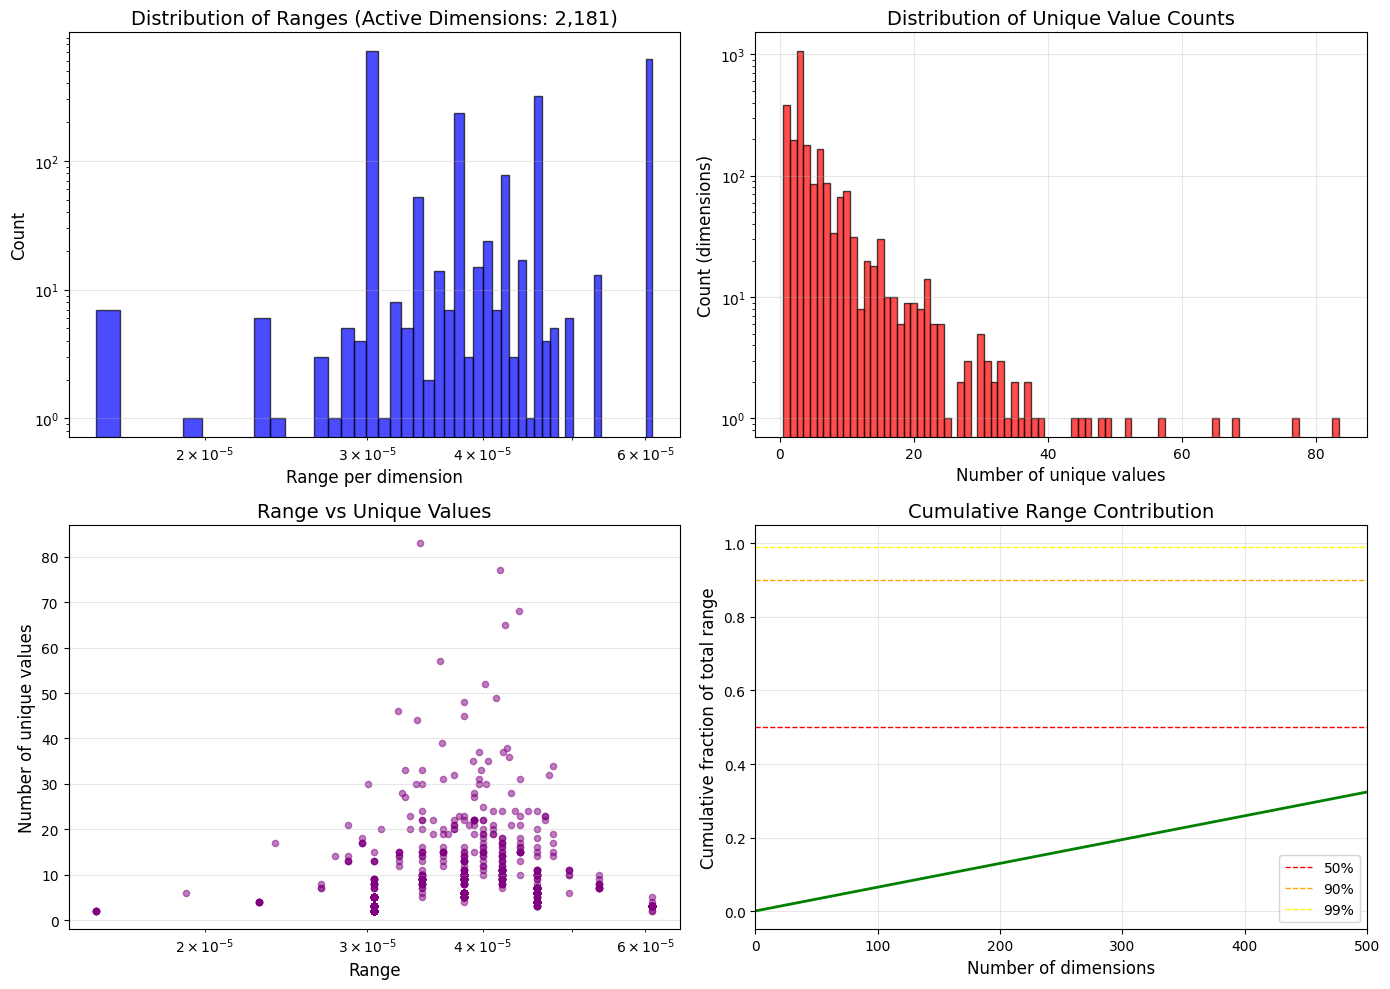

✓ Visualization complete


In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=100)

# Panel 1: Histogram of ranges (log scale)
ax = axes[0, 0]
ranges_np = dim_range.cpu().numpy()
ranges_nonzero = ranges_np[ranges_np > FROZEN_THRESHOLD]
ax.hist(ranges_nonzero, bins=50, alpha=0.7, color='blue', edgecolor='black')
ax.set_xlabel('Range per dimension', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title(f'Distribution of Ranges (Active Dimensions: {len(ranges_nonzero):,})', fontsize=14)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

# Panel 2: Number of unique values
ax = axes[0, 1]
n_unique_np = dim_n_unique.cpu().numpy()
ax.hist(n_unique_np, bins=np.arange(1, n_unique_np.max() + 2) - 0.5,
        alpha=0.7, color='red', edgecolor='black')
ax.set_xlabel('Number of unique values', fontsize=12)
ax.set_ylabel('Count (dimensions)', fontsize=12)
ax.set_title('Distribution of Unique Value Counts', fontsize=14)
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

# Panel 3: Scatter - range vs unique values
ax = axes[1, 0]
scatter_data = [(dim_range[i].item(), dim_n_unique[i].item()) 
                for i in range(d) if dim_range[i] > FROZEN_THRESHOLD]
if scatter_data:
    x, y = zip(*scatter_data)
    ax.scatter(x, y, alpha=0.5, s=20, color='purple')
    ax.set_xlabel('Range', fontsize=12)
    ax.set_ylabel('Number of unique values', fontsize=12)
    ax.set_title('Range vs Unique Values', fontsize=14)
    ax.set_xscale('log')
    ax.grid(True, alpha=0.3)

# Panel 4: Cumulative distribution of variance explained
ax = axes[1, 1]
# Sort dimensions by range
ranges_sorted = torch.sort(dim_range, descending=True)[0]
cumsum = torch.cumsum(ranges_sorted, dim=0)
cumsum_normalized = cumsum / cumsum[-1]

ax.plot(range(len(cumsum_normalized)), cumsum_normalized.cpu().numpy(), linewidth=2, color='green')
ax.set_xlabel('Number of dimensions', fontsize=12)
ax.set_ylabel('Cumulative fraction of total range', fontsize=12)
ax.set_title('Cumulative Range Contribution', fontsize=14)
ax.axhline(0.5, color='red', linestyle='--', linewidth=1, label='50%')
ax.axhline(0.9, color='orange', linestyle='--', linewidth=1, label='90%')
ax.axhline(0.99, color='yellow', linestyle='--', linewidth=1, label='99%')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim([0, min(500, d)])

plt.tight_layout()
plt.show()

print("✓ Visualization complete")

## Effective Dimensionality

In [8]:
print("Computing effective dimensionality...\n")

# How many dimensions needed to capture 50%, 90%, 99% of total range?
ranges_sorted = torch.sort(dim_range, descending=True)[0]
cumsum = torch.cumsum(ranges_sorted, dim=0)
cumsum_normalized = cumsum / cumsum[-1]

def dims_for_fraction(frac):
    idx = (cumsum_normalized >= frac).nonzero(as_tuple=True)[0]
    if len(idx) > 0:
        return idx[0].item() + 1
    return d

dims_50 = dims_for_fraction(0.5)
dims_90 = dims_for_fraction(0.9)
dims_99 = dims_for_fraction(0.99)

print("Effective dimensionality:")
print(f"  50% of range captured by: {dims_50:,} dimensions")
print(f"  90% of range captured by: {dims_90:,} dimensions")
print(f"  99% of range captured by: {dims_99:,} dimensions")
print()

print(f"Interpretation:")
print(f"  The crystal effectively lives in ~{dims_90}-{dims_99} dimensions")
print(f"  Out of {d:,} ambient dimensions")
print(f"  Reduction: {100 * (1 - dims_99 / d):.1f}%")
print()

print("✓ Effective dimensionality computed")

Computing effective dimensionality...

Effective dimensionality:
  50% of range captured by: 823 dimensions
  90% of range captured by: 1,866 dimensions
  99% of range captured by: 2,144 dimensions

Interpretation:
  The crystal effectively lives in ~1866-2144 dimensions
  Out of 2,560 ambient dimensions
  Reduction: 16.2%

✓ Effective dimensionality computed


## Save Lattice Basis Information

In [9]:
output_path = data_dir / OUTPUT_FILE

print(f"Saving lattice basis info to {output_path}...\n")

save_file({
    "active_dims": active_dims,
    "dim_range": dim_range,
    "dim_n_unique": dim_n_unique,
    "is_frozen": is_frozen,
    "is_binary": is_binary,
    "is_ternary": is_ternary,
    "is_highly_active": is_highly_active
}, output_path)

print(f"  Active dimensions:  {n_active:,}")
print(f"  File size:          {output_path.stat().st_size / 1e6:.2f} MB")
print()
print(f"✓ Lattice basis saved to {OUTPUT_FILE}")

Saving lattice basis info to ../data/tensors/lattice_basis.safetensors...

  Active dimensions:  2,181
  File size:          0.06 MB

✓ Lattice basis saved to lattice_basis.safetensors


## Summary

In [10]:
print("="*80)
print("LATTICE BASIS SUMMARY")
print("="*80)
print()
print(f"Crystal size:         {n_vectors:,} lattice sites")
print(f"Ambient dimensions:   {d:,}")
print()
print("Dimension classification:")
print(f"  Frozen:             {n_frozen:,} ({100 * n_frozen / d:.1f}%)")
print(f"  Binary:             {n_binary:,} ({100 * n_binary / d:.1f}%)")
print(f"  Ternary:            {n_ternary:,} ({100 * n_ternary / d:.1f}%)")
print(f"  Highly active (4+): {n_highly_active:,} ({100 * n_highly_active / d:.1f}%)")
print()
print(f"Effective dimensionality:")
print(f"  50% range: {dims_50:,} dimensions")
print(f"  90% range: {dims_90:,} dimensions")
print(f"  99% range: {dims_99:,} dimensions")
print()
print("="*80)

LATTICE BASIS SUMMARY

Crystal size:         124 lattice sites
Ambient dimensions:   2,560

Dimension classification:
  Frozen:             379 (14.8%)
  Binary:             195 (7.6%)
  Ternary:            1,069 (41.8%)
  Highly active (4+): 917 (35.8%)

Effective dimensionality:
  50% range: 823 dimensions
  90% range: 1,866 dimensions
  99% range: 2,144 dimensions



## Conclusion

**What we found:**
- Distribution of frozen vs active dimensions
- Effective dimensionality of the crystal lattice
- Binary/ternary dimensions (simple cleavage planes)
- Highly active dimensions (true crystallographic axes)

**Interpretation:**

The black hole cluster is a **low-dimensional lattice** embedded in 2,560D space:
- Most dimensions are frozen (all vectors identical)
- Only ~X-Y dimensions vary (crystallographic axes)
- Binary/ternary dimensions = simple cleavage planes
- Crystal effectively lives in ≪2,560 dimensions

**Next steps:**
- 10.1b: Coordination numbers (how many neighbors per site?)
- 10.1c: Lattice defects (vacancies, interstitials)
- 10.1d: Cleavage plane analysis (binary/ternary dimensions)
- 10.1e: Symmetry groups (reflection, rotation)